# Radial Basis Function Neural Networks

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as graph
from sklearn.datasets import make_circles, make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import keras.backend as K
from keras import initializers
from keras.models import Model
from keras.layers import Dense, Input, Layer
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam


graph.style.use('fivethirtyeight')


def plot_decision_boundary(model, x, y, extrapolation=1.2):
    x_min, x_max = x[:, 0].min() * extrapolation, x[:, 0].max() * extrapolation
    y_min, y_max = x[:, 1].min() * extrapolation, x[:, 1].max() * extrapolation
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    pred = model.predict(np.c_[xx.ravel(), yy.ravel()])
    pred = pred.reshape(xx.shape)

    graph.contourf(xx, yy, pred, alpha=0.4)

Using TensorFlow backend.


(1000, 2) (1000,)


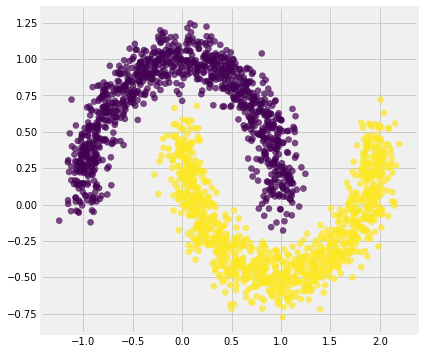

In [2]:
# Toy Data
# x, y = make_circles(n_samples=2000, noise=0.1, factor=0.6)
x, y = make_moons(2000, noise=0.1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)
print(x_train.shape, y_train.shape)

graph.figure(figsize=(6, 6))
graph.scatter(x[:, 0], x[:, 1], c=y, alpha=0.7)
graph.show()

In [3]:
# RBF Layer (AWESOME! Add this to rosey)
class RBFLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(RBFLayer, self).build(input_shape)
        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=initializers.he_uniform(),
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=initializers.constant(1.0),
                                     trainable=True)

    def call(self, inputs, **kwargs):
        c = K.expand_dims(self.centers)
        h = K.transpose(c - K.transpose(inputs))
        return K.exp(-self.betas * K.sum(h ** 2, axis=1))

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.output_dim

# Simple RBF Model

$$RBF(x) = \varphi(x) = e^{-\beta ||x - \mu_{center}||^2}$$

In [4]:
# Specify the model
inputs = Input(shape=(x_train.shape[1],))
rbf_layer = RBFLayer(10)(inputs)
outputs = Dense(1, activation='sigmoid')(rbf_layer)

rbf_model = Model(inputs, outputs)
print(rbf_model.summary())

# Create model
rbf_model.compile(Adam(lr=0.01), loss=binary_crossentropy, metrics=['accuracy'])
hist = rbf_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    callbacks=[ModelCheckpoint('tmp.h5', save_best_only=True)]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
rbf_layer_1 (RBFLayer)       (None, 10)                30        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None
Train on 1000 samples, validate on 500 samples
Epoch 1/100
1000/1000 [==============================] - 0s 244us/step - loss: 0.5193 - acc: 0.9000 - val_loss: 0.4272 - val_acc: 0.9200
Epoch 2/100
1000/1000 [==============================] - 0s 30us/step - loss: 0.3776 - acc: 0.9090 - val_loss: 0.3252 - val_acc: 0.9200
Epoch 3/100
1000/1000 [==============================] - 0s 31us/step - loss: 0.3031 

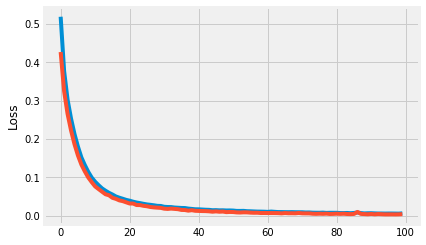

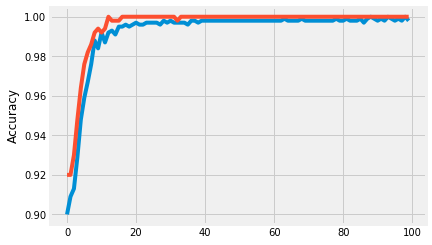

In [5]:
# Graph Results
graph.plot(hist.history['loss'], label='Train Loss')
graph.plot(hist.history['val_loss'], label='Val Loss')
graph.ylabel('Loss')
graph.show()

graph.plot(hist.history['acc'], label='Train Accuracy')
graph.plot(hist.history['val_acc'], label='Val Accuracy')
graph.ylabel('Accuracy')
graph.show()

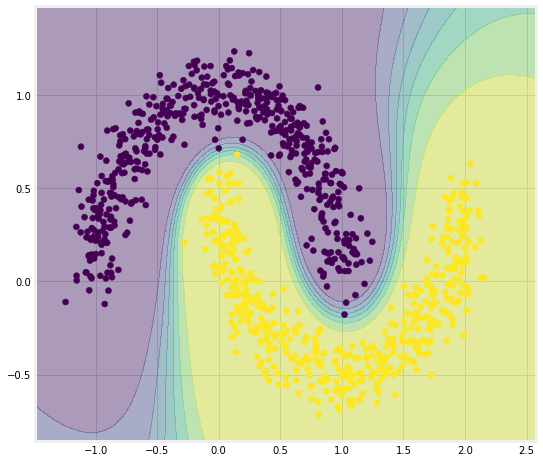

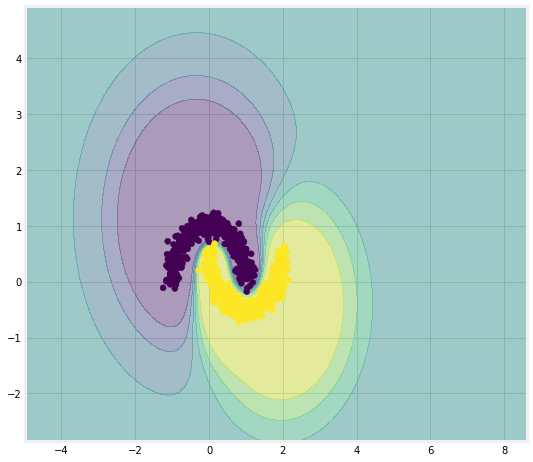

500/500 [==============================] - 0s 18us/step
Test Scores: [0.008344755299389363, 1.0]


In [6]:
graph.figure(figsize=(8, 8))
plot_decision_boundary(rbf_model, x_train, y_train)
graph.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
graph.show()

graph.figure(figsize=(8, 8))
plot_decision_boundary(rbf_model, x_train, y_train, extrapolation=4)
graph.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
graph.show()

print(f'Test Scores: {rbf_model.evaluate(x_test, y_test)}')

_Stephen Anthony Rose_